In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

# https://github.com/NickAlger/helper_functions/blob/master/conforming_grid_convolution.py
from conforming_grid_convolution import conforming_grid_convolution

In [2]:
min1 = np.array([0.23, -0.35])
hh = np.array([0.0125, 0.01])
min2 = min1 + np.array([30., 57.]) * hh

d = len(min1)

F1_shape = (95,87)
F2_shape = (151,198)

max1 = min1 + hh * (np.array(F1_shape)-1)
max2 = min2 + hh * (np.array(F2_shape)-1)

p1 = np.array([0.35, -0.25])
p2 = np.array([1.35, 1.25])

xx1 = np.linspace(min1[0], max1[0], F1_shape[0])
yy1 = np.linspace(min1[1], max1[1], F1_shape[1])
X1, Y1 = np.meshgrid(xx1, yy1, indexing='ij')

xx2 = np.linspace(min2[0], max2[0], F2_shape[0])
yy2 = np.linspace(min2[1], max2[1], F2_shape[1])
X2, Y2 = np.meshgrid(xx2, yy2, indexing='ij')

F1_volume= 1.35


Text(0.5, 1.0, 'F1')

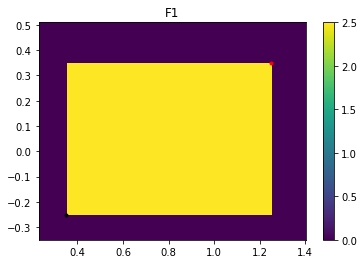

In [3]:
b_width = 0.9
b_height = 0.6

F1 = 2.5 * (p1[0] < X1) * (X1 < p1[0] + b_width) * (p1[1] < Y1) * (Y1 < p1[1] + b_height)

element_volume = np.prod(hh)
F1_volume = np.sum(F1) * element_volume
print('F1_volume=', F1_volume)

plt.pcolor(X1, Y1, F1)
plt.colorbar()
plt.plot(p1[0], p1[1], '.k')
plt.plot(p1[0] + b_width, p1[1] + b_height, '.r')
plt.title('F1')

F2_volume= 0.9999984661196425


Text(0.5, 1.0, 'F2')

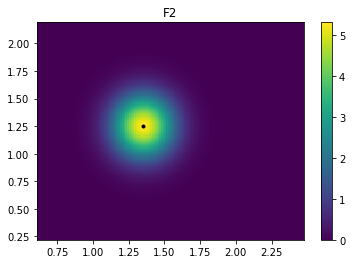

In [5]:
def make_2D_grid_gaussian(mu, Sigma, X, Y):
    d = len(X.shape)
    C = np.power(2 * np.pi, -d/2.) * np.power(np.linalg.det(Sigma), -1./2.)
    
    zz = np.vstack([X.reshape(-1), Y.reshape(-1)]) - mu.reshape((-1,1))
    F = C * np.exp(-0.5 * np.sum(zz * np.linalg.solve(Sigma, zz), axis=0).reshape(-1)).reshape(X.shape)
    return F

ss = np.array([0.15, 0.2])
Sigma = np.diag(ss**2)
F2 = make_2D_grid_gaussian(p2, Sigma, X2, Y2)

F2_volume = np.sum(F2) * element_volume
print('F2_volume=', F2_volume)

plt.pcolor(X2, Y2, F2)
plt.colorbar()
plt.plot(p2[0], p2[1], '.k')
plt.title('F2')

dt_fft= 0.003280162811279297
dt_direct= 5.807126045227051
dt_auto= 0.003561735153198242
F3_volume= 1.3499979292615174


Text(0.5, 1.0, 'convolution of f1(x-p1) and f2(x-p2)')

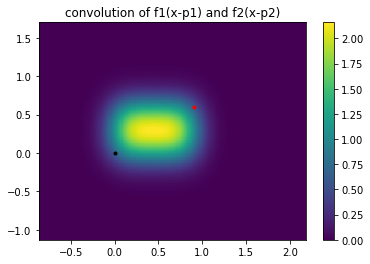

In [6]:
t = time()
F3, min3, max3 = conforming_grid_convolution(F1, min1, max1, F2, min2, max2, p1=p1, p2=p2, method='fft')
dt_fft = time() - t
print('dt_fft=', dt_fft)

t = time()
F3, min3, max3 = conforming_grid_convolution(F1, min1, max1, F2, min2, max2, p1=p1, p2=p2, method='direct')
dt_direct = time() - t
print('dt_direct=', dt_direct)

t = time()
F3, min3, max3 = conforming_grid_convolution(F1, min1, max1, F2, min2, max2, p1=p1, p2=p2, method='auto')
dt_auto = time() - t
print('dt_auto=', dt_auto)

F3_volume = np.sum(F3) * element_volume
print('F3_volume=', F3_volume)

xx3 = np.linspace(min3[0], max3[0], F3.shape[0])
yy3 = np.linspace(min3[1], max3[1], F3.shape[1])
X3, Y3 = np.meshgrid(xx3, yy3, indexing='ij')

plt.pcolor(X3, Y3, F3)
plt.colorbar()

plt.plot(0, 0, '.k')
plt.plot(b_width, b_height, '.r')
plt.title('convolution of f1(x-p1) and f2(x-p2)')

Text(0.5, 1.0, 'G_B')

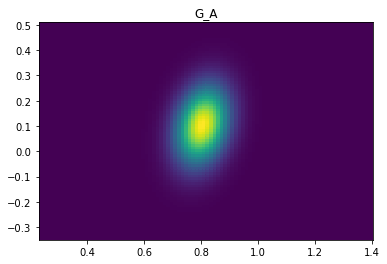

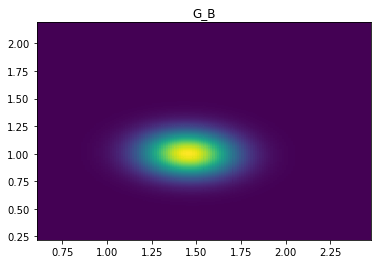

In [7]:
mu_A = np.array([0.8, 0.1])
Sigma_A = np.array([[0.004, 0.0015], 
                    [0.0015, 0.011]])
G_A = make_2D_grid_gaussian(mu_A, Sigma_A, X1, Y1)

plt.pcolor(X1, Y1, G_A)
plt.title('G_A')

mu_B = np.array([1.45, 1.0])
Sigma_B = np.array([[0.033, -0.001], 
                    [-0.001, 0.020]])
G_B = make_2D_grid_gaussian(mu_B, Sigma_B, X2, Y2)

plt.figure()
plt.pcolor(X2, Y2, G_B)
plt.title('G_B')

err_conv= 4.2707996909004765e-05


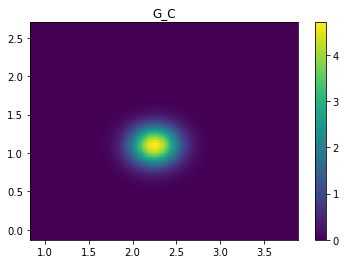

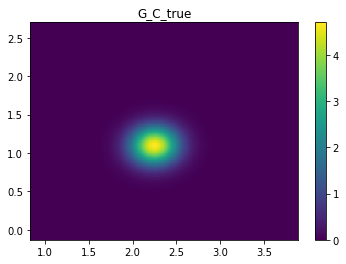

In [8]:
G_C, min5, max5 = conforming_grid_convolution(G_A, min1, max1, G_B, min2, max2, method='fft')

xx_C = np.linspace(min5[0], max5[0], G_C.shape[0])
yy_C = np.linspace(min5[1], max5[1], G_C.shape[1])
X_C, Y_C = np.meshgrid(xx_C, yy_C, indexing='ij')

plt.figure()
plt.pcolor(X_C, Y_C, G_C)
plt.colorbar()
plt.title('G_C')

G_C_true = make_2D_grid_gaussian(mu_A + mu_B, Sigma_A + Sigma_B, X_C, Y_C)

plt.figure()
plt.pcolor(X_C, Y_C, G_C_true)
plt.colorbar()
plt.title('G_C_true')

err_conv = np.linalg.norm(G_C - G_C_true) / np.linalg.norm(G_C_true)
print('err_conv=', err_conv)